# HOMEWORK 2 KURAMOTO MODEL

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
from multiprocessing import Pool
from collections import namedtuple
from tqdm import tqdm
import seaborn as sns
import matplotlib.gridspec as gridspec
from colorsys import hls_to_rgb
class AttributeDict(dict):
    def __getattr__(self, attr):
        return self[attr]
    def __setattr__(self, attr, value):
        self[attr] = value

### build model

In [2]:
def run(phases, ph_0, time, w, dt, noise, K, N):
    # считаем фазы
    i = 0
    phases[:, i] = ph_0
    while i+1 < len(time):
        x = np.sum(np.sin(phases[:, i] - phases[:, i][:, np.newaxis]), axis=0) * (K / N)
        y = 2 * np.pi * w(time[i+1])
        z = phases[:, i]
        phases[:, i+1] = z + dt * (x + y + noise)
        i += 1
    # считаем сигнал
    complex_signal = np.exp(phases * 1j)
    model_signal = np.mean(complex_signal, axis=0)
    frec, psd = welch(model_signal.real, fs=int(1/dt), scaling="spectrum", nperseg =len(time))
    return model_signal, frec, psd
    
    

def Kuramoto(c):
    time = np.arange(0, c.T, c.dt)
    noise = np.random.normal(0, 1, size=c.N)
    ph_0 = np.random.uniform(-np.pi, np.pi, size=c.N)
    w = c.w
    
    phases = np.zeros((c.N, len(time)))
    
    return run(phases, ph_0, time, w, c.dt, noise, c.K, c.N)

In [4]:
def run_exp(frequency, first_exp):
    config = AttributeDict({
                        'N': 500,
                        'K': 1.5,
                        'dt': 0.01,
                        'T': 60.0,
                        })
    if first_exp:
        config['w'] = lambda t:  np.random.uniform(0.75*frequency, 1.25*frequency, size=config.N)
    else:
        w_freq = lambda f: np.random.uniform(0.75*f, 1.25*f, size=config.N)
        config['w'] = lambda t:  w_freq(10) if (0 < t <= 15) or (45 < t) else w_freq(20) if 15 < t <= 30 else w_freq(25)
    
    return Kuramoto(config)



### first simulation

In [5]:
frecs = [10] * 10 + [15] * 5 + [25] * 5
with Pool(4) as p:
    exp1 = p.starmap(run_exp, tqdm([(frec, True) for frec in frecs], position=0,leave=False))

### second simulation

In [6]:
with Pool(4) as p:
    exp2 = p.starmap(run_exp, tqdm([(_, False) for _ in range(20)], position=0,leave=False))

### вычисления

In [7]:
freq_exp1 = exp1[0][1]
power_exp1 = np.array([i[-1] for i in exp1]).mean(axis=0)

freq_exp2 = exp2[0][1]
power_exp2 = np.array([i[-1] for i in exp2]).mean(axis=0)

# считаем plv

signs1 = np.array([i[0] for i in exp1])
signs1_ = np.conj(signs1)
PLV = (signs1 @ signs1_.T) / signs1.shape[-1] 

r, arg = np.abs(PLV), np.angle(PLV) 
h = (arg + np.pi)  / (2 * np.pi) + 0.5
l = 1.0 - 1.0 / (1.0 + r**0.3)
s = 0.8

plv_im = np.array(np.vectorize(hls_to_rgb) (h,l,s)).swapaxes(0,2)

# считаем psd по времени
table = []
signals = np.array([i[0] for i in exp2]).mean(axis=0)
for signal in np.split(signals, 60):
    frec, psd = welch(signal, fs=int(1/0.01), scaling="spectrum", nperseg =len(signal), nfft=len(signal)*1)
    table.append(psd)

/Users/sergekulesh/opt/miniconda3/lib/python3.7/site-packages/scipy/signal/spectral.py:1812: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


### графики

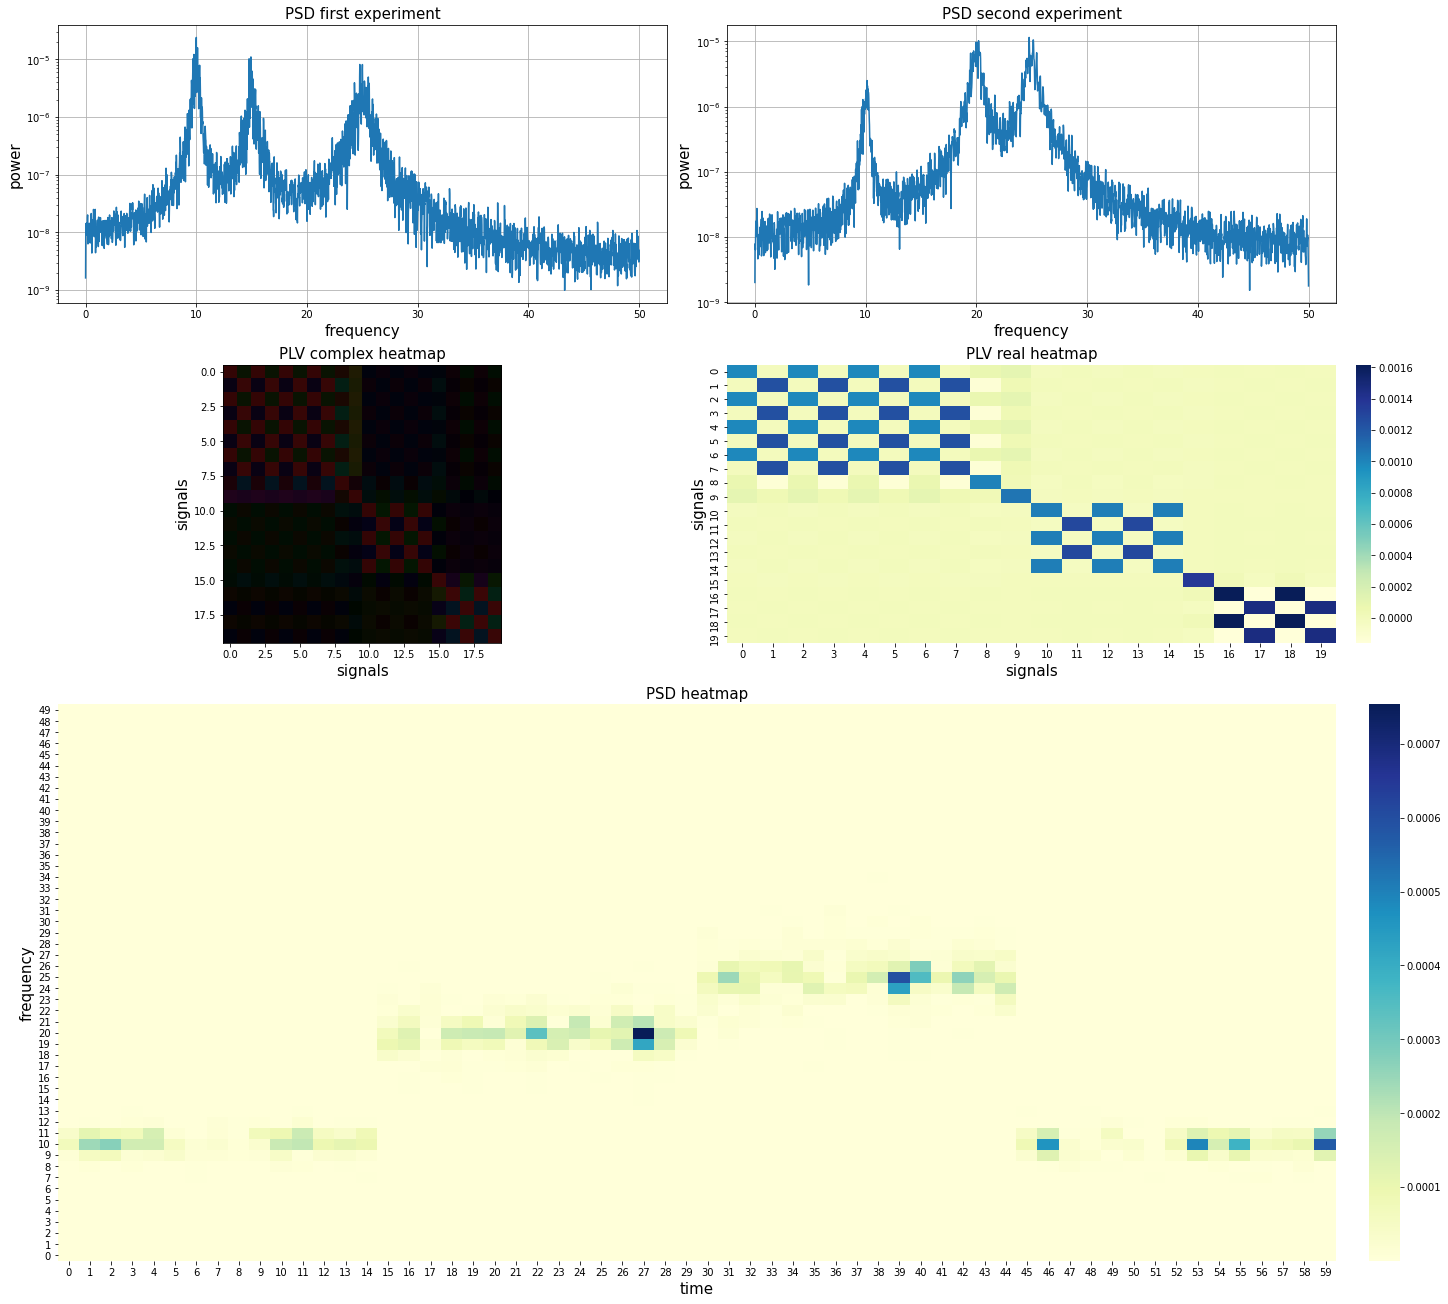

In [53]:
fig = plt.figure(constrained_layout=True, figsize=(20, 18))
spec = gridspec.GridSpec(ncols=8, nrows=16, figure=fig)

psd1 = fig.add_subplot(spec[0:4, 0:4])
psd2 = fig.add_subplot(spec[0:4, 4:8])
plv = fig.add_subplot(spec[4:8, 0:4])
plv_map = fig.add_subplot(spec[4:8, 4:8])
psd_map = fig.add_subplot(spec[8:16, :])

# # psd1
psd1.semilogy(exp1[0][1], np.array([i[-1] for i in exp1]).mean(axis=0))
psd1.set_title('PSD first experiment', fontsize=15)
psd1.set_xlabel('frequency', fontsize=15)
psd1.set_ylabel('power', fontsize=15)
# # psd2
psd2.semilogy(exp2[0][1], np.array([i[-1] for i in exp2]).mean(axis=0))
psd2.set_title('PSD second experiment', fontsize=15)
psd2.set_xlabel('frequency', fontsize=15)
psd2.set_ylabel('power', fontsize=15)
# # plv
plv.imshow(plv_im, alpha=5.0)
plv.set_xlabel('signals', fontsize=15)
plv.set_ylabel('signals', fontsize=15)
plv.set_title('PLV complex heatmap', fontsize=15)

# # plv map
sns.heatmap(PLV.real, cmap="YlGnBu", ax=plv_map)
plv_map.set_xlabel('signals', fontsize=15)
plv_map.set_ylabel('signals', fontsize=15)
plv_map.set_title('PLV real heatmap', fontsize=15)

# psd map
sns.heatmap(np.array(table).T[:50], cmap="YlGnBu", ax=psd_map)
psd_map.set_xlabel('time', fontsize=15)
psd_map.set_ylabel('frequency', fontsize=15)
psd_map.set_title('PSD heatmap', fontsize=15)
psd_map.invert_yaxis()
# # grid
for mg in [psd1, psd2]:
    mg.grid()
plt.show()

### выводы

- Видны явно выраженные пики в заданных частотах в обоих эксперементах по усредненному сигналу (в 10, 15, 25)
- Фазовая синхрония ярко выражена у сигналов с одинаковыми частотами
- PSD по времени выделяет заданные частоты усредненного сигнала по времени
